# **IMPORTS**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
from tensorflow.keras.applications import EfficientNetB2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import datasets, Input, Sequential
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Rescaling, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D

```
⠀⠀⠀⠀⠀⠀⣀⣤⡤
⠀⠀⠀⠀⢀⣾⣿⠋
⠀⠀⠀⣠⣾⣿⡟
⠀⠀⢸⠛⠉⢹⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡠⠄⠠⣀
⠀⠀⡘⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠖⠉⠀⠀⠀⣾⣿⣦⡀
⠀⠀⡇⠀⠀⠀⢡⠄⠀⠀⣀⣀⣀⣠⠊⠀⠀⠀⠀⡠⠞⠛⠛⠛⠛⡀
⠀⠀⢃⠀⠀⠀⠀⠗⠚⠉⠉⠀⠈⠁⠀⠀⠀⢀⡔⠁⠀
⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⣶⣄⠲⡎
⠀⠀⠀⠃⠀⠀⢠⣤⡀⠀⠀⠀⠀⣿⣿⣿⠀⠘⡄
⠀⠀⠀⡆⠀⠀⣿⣿⡇⠀⠀⠀⠀⠈⠛⠉⣴⣆⢹⡄
⠀⠀⠀⣇⢰⡧⣉⡉⠀⠀⢀⡀⠀⣀⣀⣠⣿⡷⢠⡇
⠀⠀⠀⢻⠘⠃⠈⠻⢦⠞⠋⠙⠺⠋⠉⠉⠉⢡⠟
⠀⠀⠀⠀⠳⢄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠋⠀⠀
```

# **SETTINGS**
---

In [4]:
# Activates XLA (for JIT compiler)
os.environ["TF_XLA_FLAGS"]= "--tf_xla_enable_xla_devices"

# Uses the right memory when using GPU
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]= "true"

# **DATA**

---

In [5]:
# Loading CIFAR-10
data= datasets.cifar10.load_data()

In [6]:
# Spliting the data from the Dataset
(X_train, y_train), (X_test, y_test)= data

In [7]:
print(f"Shape of X-train: {X_train.shape}\nShape of X-test: {X_test.shape}")
print(f"Shape of y-train: {y_train.shape}\nShape of y-test: {y_test.shape}")

Shape of X-train: (50000, 32, 32, 3)
Shape of X-test: (10000, 32, 32, 3)
Shape of y-train: (50000, 1)
Shape of y-test: (10000, 1)


In [8]:
class_names= [
  "airplane", "automobile", "bird", "cat",
  "deer", "dog", "frog", "horse", "ship", "truck"
]

/tmp/ipython-input-3158793262.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y_train[idx])])


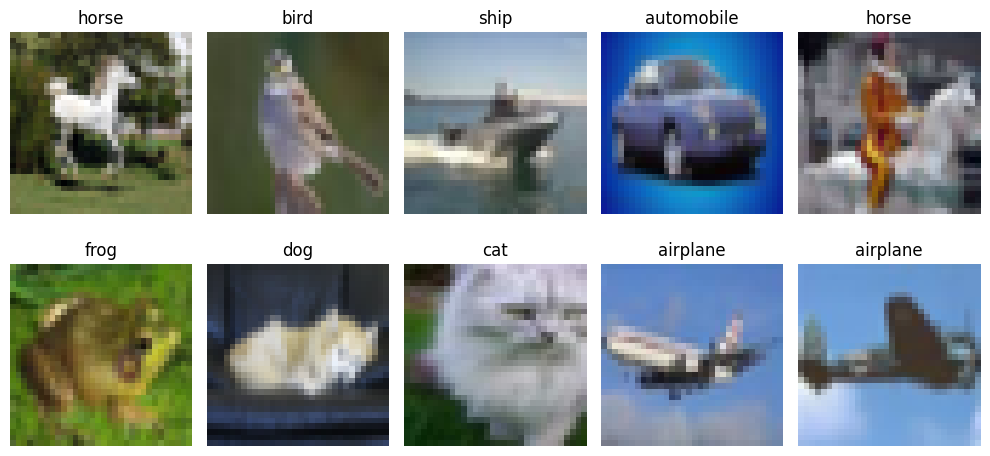

In [9]:
plt.figure(figsize=(10, 5))
# shows random 10 images from dataset
for i in range(10):
  idx= np.random.randint(len(X_train))
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_train[idx])
  plt.title(class_names[int(y_train[idx])])
  plt.axis("off")

plt.tight_layout()
plt.show()

# **PREPROCESSING DATA**

---

## Functions

In [10]:
def resize_and_preprocess_in_chunks(X, target_size=(64, 64), batch_size=64, dtype=np.float32):
  n_samples= X.shape[0]
  X_resized= np.empty((n_samples, target_size[0], target_size[1], X.shape[-1]), dtype=dtype)

  for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X[i:end]
    batch_resized = tf.image.resize(batch, target_size, method='bilinear')
    batch_resized = preprocess_input(batch_resized.numpy().astype(dtype))
    X_resized[i:end] = batch_resized
    if i % (35 * batch_size) == 0:
      print(f"  → Processed {end}/{n_samples} images...")

  return X_resized

In [11]:
target_size= (128, 128)

In [12]:
# Resize and preprocess X_train (on the same step to save RAM)
X_train_pp= resize_and_preprocess_in_chunks(X_train, target_size=(128, 128))

  → Processed 64/50000 images...
  → Processed 2304/50000 images...
  → Processed 4544/50000 images...
  → Processed 6784/50000 images...
  → Processed 9024/50000 images...
  → Processed 11264/50000 images...
  → Processed 13504/50000 images...
  → Processed 15744/50000 images...
  → Processed 17984/50000 images...
  → Processed 20224/50000 images...
  → Processed 22464/50000 images...
  → Processed 24704/50000 images...
  → Processed 26944/50000 images...
  → Processed 29184/50000 images...
  → Processed 31424/50000 images...
  → Processed 33664/50000 images...
  → Processed 35904/50000 images...
  → Processed 38144/50000 images...
  → Processed 40384/50000 images...
  → Processed 42624/50000 images...
  → Processed 44864/50000 images...
  → Processed 47104/50000 images...
  → Processed 49344/50000 images...


In [13]:
# Resize and preprocess X_test (on the same step to save RAM)
X_test_pp=  resize_and_preprocess_in_chunks(X_test, (128, 128))

  → Processed 64/10000 images...
  → Processed 2304/10000 images...
  → Processed 4544/10000 images...
  → Processed 6784/10000 images...
  → Processed 9024/10000 images...


In [14]:
# Apply OHE to cat data (y)
y_train_cat= to_categorical(y_train, 10)
y_test_cat=  to_categorical(y_test, 10)

In [15]:
localpath= "/content/cifar10_efficientnetb2_preprocessed.npz"
filepath= "/content/drive/MyDrive/cdd_ironhack_p4/"

# saves compressed data (our resized and preprocessed imgs) to local
"""np.savez_compressed(
  localpath,          # 224x224 imgs last a 21GB file and more or less 40 minutes to save on local
  X_train= X_train_pp,
  X_test=  X_test_pp,
  y_train= y_train_cat,
  y_test=  y_test_cat
)"""

'np.savez_compressed(\n  localpath,          # 224x224 imgs last a 21GB file and more or less 40 minutes to save on local\n  X_train= X_train_pp,\n  X_test=  X_test_pp,\n  y_train= y_train_cat,\n  y_test=  y_test_cat\n)'

# **USING *EfficientNetB2***

---

**EfficientNetB2** doesn't expect a shape minimum of the images dimensions, so we can use the native shape `32x32px`, but the issue is *that* the model was trained using `224x224px` images. Naturally, higher resolutions means to a better performance on the model. Reshaping the images to `224x224px` is **so expensive**, and we cannot efford that —we can use `on-the-fly` solution to improve this, but `I` lack the knowladge for this, so, instead, I reshape to `128x128px` and it improves the performance on `±20%` accuracy.

In [16]:
# We load the basemodel B2 and froze it
base_model= EfficientNetB2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable= False

In [17]:
# We made our custom top classifier
model= Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(128, activation='relu'),
  Dropout(0.5), # drop half neurons to avoid overfitting on a very dense model (B2)
  Dense(256, activation='relu', kernel_regularizer= l2(0.001)), # Add l2 regularizer
  Dense(10, activation='softmax')
])

In [18]:
# We C O M P I L E !
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
# AND WE TRAIN!
history= model.fit(
  X_train_pp, y_train_cat,
  validation_split=0.2,
  epochs=10,
  batch_size=64
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 73ms/step - accuracy: 0.7482 - loss: 0.9484 - val_accuracy: 0.8799 - val_loss: 0.4569
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8639 - loss: 0.5059 - val_accuracy: 0.8862 - val_loss: 0.3968
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8768 - loss: 0.4287 - val_accuracy: 0.8826 - val_loss: 0.3832
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8799 - loss: 0.4014 - val_accuracy: 0.8885 - val_loss: 0.3585
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8840 - loss: 0.3747 - val_accuracy: 0.8921 - val_loss: 0.3510
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8882 - loss: 0.3576 - val_accuracy: 0.8931 - val_loss: 0.3513
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8959 - loss: 0.3393 - val_accuracy: 0.8923 - val_loss: 0.3518
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8968 - loss: 0.3273 - 

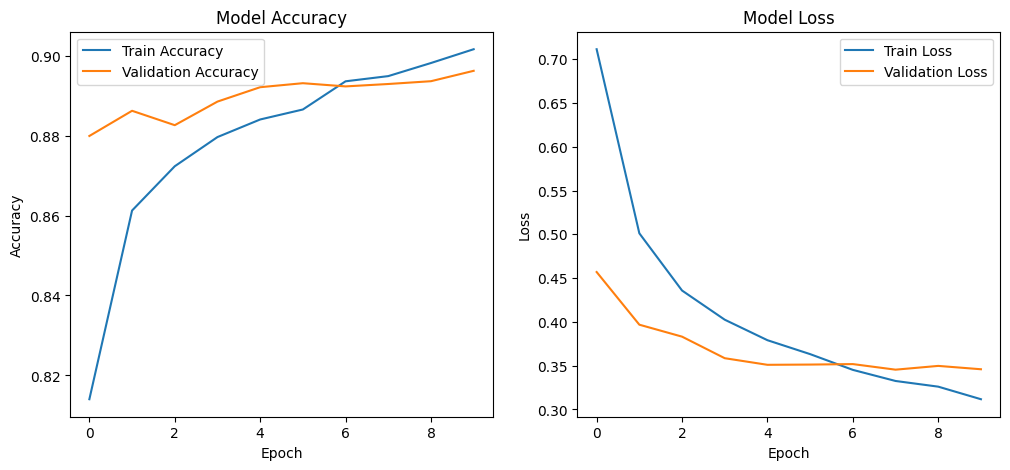

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# Then, we evaluate the model
test_loss, test_acc = model.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8862 - loss: 0.3797
Test Accuracy: 0.8881


In [22]:
# And store its predictions
y_pred_probs = model.predict(X_test_pp)
y_pred= np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step


In [23]:
report= classification_report(y_test, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.91      0.85      0.88      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.89      0.86      0.88      1000
         cat       0.79      0.79      0.79      1000
        deer       0.84      0.88      0.86      1000
         dog       0.86      0.84      0.85      1000
        frog       0.90      0.93      0.92      1000
       horse       0.93      0.91      0.92      1000
        ship       0.91      0.94      0.92      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



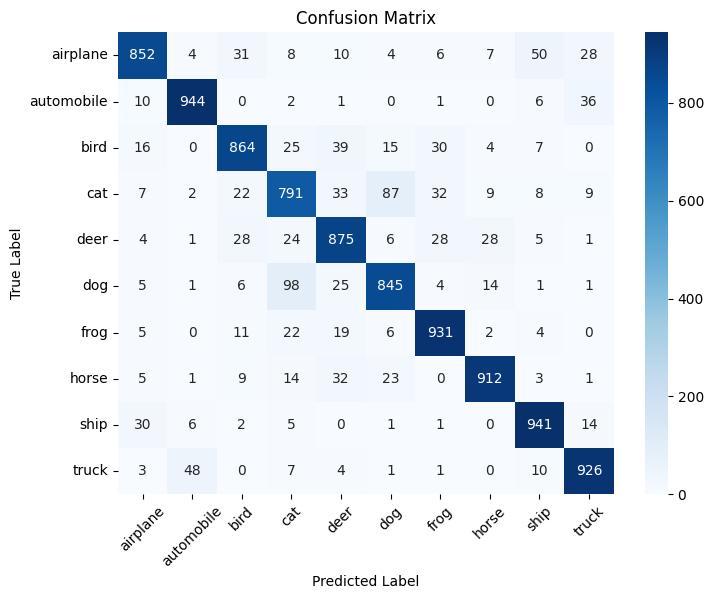

In [24]:
cm= confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


>Good model but not enough. We have lil' overfit on `train` and some high values on confussion like `cat and dog`.

# **MODEL TUNING**

---

## Unfreezing the last layers

In [90]:
len(base_model.layers)

340

In [115]:
#  Freeze all layers except the last N layers

base_model.trainable= True                     # unfroze the model
fine_tune_at = len(base_model.layers) - 165    # select the 165 last layers
for layer in base_model.layers[:fine_tune_at]: # kept the last 165 layers to use
  layer.trainable = False                      # froze the model

## Top Classifier

In [116]:
# We made our custom top classifier
model= Sequential([
  base_model,                     # recreate the model (avoids retraining)
  GlobalAveragePooling2D(),       # apply an average pool to 2d layer
  Dense(128, activation='relu'),  # dense layer using ReLU
  Dropout(.4),                    # drop 40$ of the prev. dense layer
  Dense(256, activation='relu', kernel_regularizer= l2(0.001)), # dense layer using ReLU and l2 regularizer to avoid overfit
  Dropout(.3),                    # drop 60% of the prev. dense layer
  Dense(10, activation='softmax') # output layer using softmax
])

## Model re-compile

In [117]:
# Compile model with a lower learning rate
model.compile(                            # recompile model
  optimizer= Adam(learning_rate= 5e-6),   # using Adam with 5e-6 learning rate
  loss=      'categorical_crossentropy',  # using categorical crossentropy as loss value handler
  metrics=   ['accuracy']                 # focusing accuracy on metrics
)

## Callbacks

In [118]:
# Reduce learning rate when learning doesn't improve
reduce_lr= ReduceLROnPlateau( # reduce learning rate on plateau
  monitor=  "val_loss",       # to reduce val_loss
  factor=   0.5,              # when detects, reduces on 50% the learning rate
  patience= 2,                # every 2 epochs w/o improvement
  min_lr=   1e-8,             # with a minimun 1e-8% learning rate
  verbose=  1                 # verbose
)

In [119]:
# Allows the model to stop early to prevent overfitting
early_stop= EarlyStopping(   # early stopping to avoid overfit
  monitor=    "val_loss",    # to reduce val_loss
  patience=   3,             # stops after 3 epochs w/o improvements
  restore_best_weights=True, # keeps the better model
  min_delta=  1e-5,          # allows "improvement" only if val_loss improves 1e-5 units
  verbose=    1              # verbose
)

## Fine tune

In [121]:
# Continue training (fine-tuning)
fine_tune_epochs= 3
total_epochs=     11 + fine_tune_epochs

history_fine=       model.fit(
  X_train_pp, y_train_cat,
  validation_split=  .3,
  epochs=            total_epochs,
  initial_epoch=     4,
  batch_size=        64,
  callbacks=         [early_stop, reduce_lr],
)

Epoch 4/14
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 56ms/step - accuracy: 0.3596 - loss: 2.1830 - val_accuracy: 0.9369 - val_loss: 0.9370 - learning_rate: 5.0000e-06
Epoch 5/14
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9207 - loss: 0.9672 - val_accuracy: 0.9391 - val_loss: 0.4953 - learning_rate: 5.0000e-06
Epoch 6/14
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9587 - loss: 0.5400 - val_accuracy: 0.9399 - val_loss: 0.4073 - learning_rate: 5.0000e-06
Epoch 7/14
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9610 - loss: 0.4049 - val_accuracy: 0.9394 - val_loss: 0.3933 - learning_rate: 5.0000e-06
Epoch 8/14
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9623 - loss: 0.3583 - val_accuracy: 0.9400 - val_loss: 0.3944 - learning_rate: 5.0000e-06
Epoch 9/14
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9639 - loss: 0.3298
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - ac

## Metrics

# **PROBAR FOCAL LOSS EN CAT**

In [122]:
test_loss, test_acc= model.evaluate(X_test_pp, y_test_cat)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9353 - loss: 0.4121
Test Accuracy after fine-tuning: 0.9380


In [123]:
report= classification_report(y_test, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.91      0.85      0.88      1000
  automobile       0.94      0.94      0.94      1000
        bird       0.89      0.86      0.88      1000
         cat       0.79      0.79      0.79      1000
        deer       0.84      0.88      0.86      1000
         dog       0.86      0.84      0.85      1000
        frog       0.90      0.93      0.92      1000
       horse       0.93      0.91      0.92      1000
        ship       0.91      0.94      0.92      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



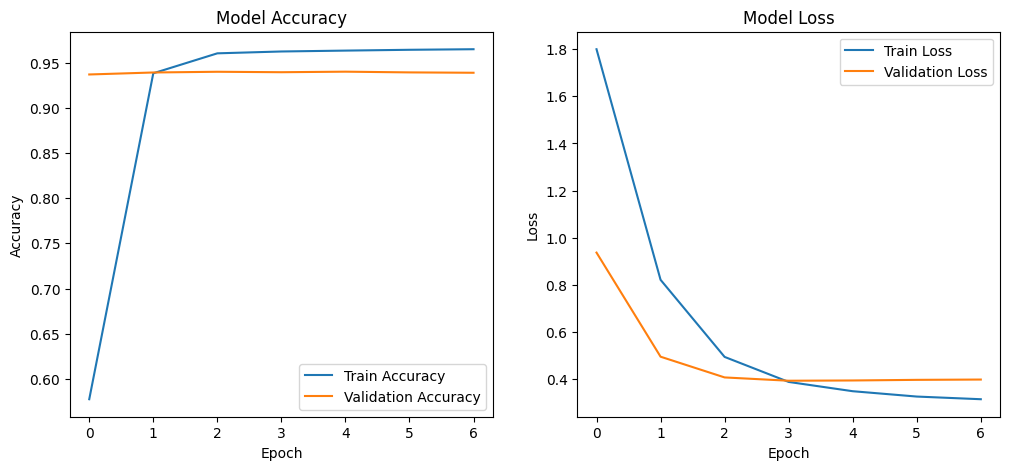

In [124]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()